## [기말과제] 제8회 시도지사선거 데이터 분석 
1. 클러스터 분석 
- 클러스터 숫자선정 사유 
- 어떠한 방법론으로 했는지 
- 클러스터별 측정 시나리오 
2. 회귀분석 
- 시나리오 자유 
- 회귀식의 설명 계수의미와 R², P-value 
3. 정당별 득표율 (민주당 승률-지도표기)

### # 기초데이터 세팅

In [44]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
import re

In [23]:
## 엑셀파일 로드 (두번째 행을 제거하고 로드 )
file_path = "8회_시도지사선거.xlsx"
df = pd.read_excel(file_path, sheet_name="시·도지사선거", skiprows=[1])
print(df.head(10))

# 그래프 한글변환 오류함수
def set_graph_font():
    plt.rcParams['axes.unicode_minus'] = False
    if platform.system() == 'Darwin':     # IOS
        rc('font', family='AppleGothic')
    elif platform.system() == 'Windows':
        path = "c:/Windows/Fonts/malgun.ttf"
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family=font_name)
    elif platform.system() == 'Linux':
        path = "/usr/share/fonts/truetype/freefont/malgun.ttf"
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family=font_name)
    else:
        print('폰트를 적용할수 없습니다') 

    선거구명 구시군명    읍면동명      구분     선거인수     투표수     후보자별 득표수 Unnamed: 7  \
0  서울특별시  종로구     NaN     NaN      NaN     NaN  더불어민주당\n송영길  국민의힘\n오세훈   
1  서울특별시  종로구      합계     NaN  129,816  70,657       28,327     40,145   
2  서울특별시  종로구    거소투표     NaN      154     147           44         84   
3  서울특별시  종로구  관외사전투표     NaN    8,069   8,067        3,450      4,361   
4  서울특별시  종로구   청운효자동      소계    9,179   4,887        2,094      2,630   
5  서울특별시  종로구   청운효자동  관내사전투표    1,732   1,732          848        828   
6  서울특별시  종로구   청운효자동   선거일투표    7,447   3,155        1,246      1,802   
7  서울특별시  종로구     사직동      소계    8,057   4,452        1,523      2,785   
8  서울특별시  종로구     사직동  관내사전투표    1,699   1,699          741        904   
9  서울특별시  종로구     사직동   선거일투표    6,358   2,753          782      1,881   

  Unnamed: 8  Unnamed: 9 Unnamed: 10 Unnamed: 11       계 무효투표수     기권수  
0   정의당\n권수정  기본소득당\n신지혜    무소속\n김광종          \n     NaN   NaN     NaN  
1      1,151         226         167   

### 1. 클러스터 분석 

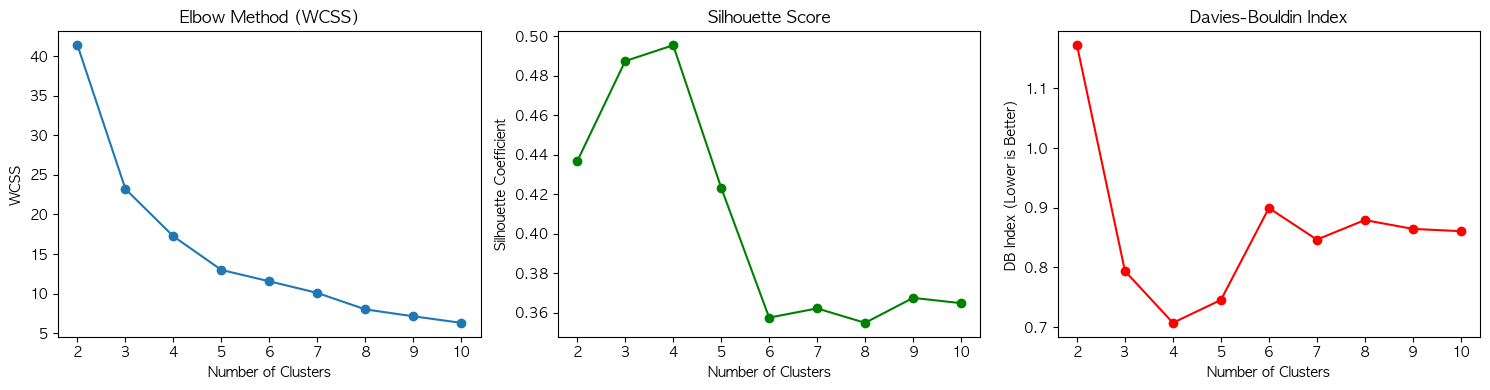

In [ ]:
set_graph_font()

# 클러스터 숫자선정 
df_filtered = df[df['읍면동명'] == '합계'].copy()

# 2. 수치형 변환
cols_to_convert = ['선거인수', '투표수', '기권수', '무효투표수',
                   '후보자별 득표수', 'Unnamed: 7', '계']
for col in cols_to_convert:
    df_filtered[col] = df_filtered[col].astype(str).str.replace(',', '').astype(float)

# 3. 파생변수 생성 및 정규화
#cluster_data = df_filtered.groupby('선거구명').sum(numeric_only=True).reset_index()
cluster_data = df_filtered.copy().reset_index(drop=True)
cluster_data['투표율'] = cluster_data['투표수'] / cluster_data['선거인수']
cluster_data['기권율'] = cluster_data['기권수'] / cluster_data['선거인수']
cluster_data['무효율'] = cluster_data['무효투표수'] / cluster_data['투표수']
cluster_data['민주당비율'] = cluster_data['후보자별 득표수'] / cluster_data['계']
cluster_data['국힘비율'] = cluster_data['Unnamed: 7'] / cluster_data['계']

features = ['투표율', '기권율', '무효율', '민주당비율', '국힘비율']
X_scaled = MinMaxScaler().fit_transform(cluster_data[features])

# 4. 군집 수 범위 정의
range_n_clusters = range(2, 11)
wcss = []
silhouette_scores = []
db_scores = []

# 5. 각 지표 계산 루프
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # Elbow
    wcss.append(kmeans.inertia_)

    # Silhouette
    silhouette_scores.append(silhouette_score(X_scaled, labels))

    # Davies-Bouldin
    db_scores.append(davies_bouldin_score(X_scaled, labels))

# 6. 시각화
plt.figure(figsize=(15, 4))

# Elbow Method
plt.subplot(1, 3, 1)
plt.plot(range_n_clusters, wcss, marker='o')
plt.title("Elbow Method (WCSS)")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")

# Silhouette Score
plt.subplot(1, 3, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")

# Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(range_n_clusters, db_scores, marker='o', color='red')
plt.title("Davies-Bouldin Index")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index (Lower is Better)")

plt.tight_layout()
plt.show()

#### 클러스터 수 기준 
1. Elbow Method : WCSS가 2→3→4에서 급격히 감소하다가, 4 이후부터는 감소폭이 완만해집니다. 즉, 4에서 팔꿈치(Elbow)가 보입니다.  
2. Silhouette Score : 실루엣 점수는 3, 4에서 가장 높으며, 4에서 거의 최고점입니다. 5 이상에서는 점수가 뚜렷하게 떨어집니다. 즉, 4에서 군집의 응집도와 분리도가 가장 좋습니다.
3. Davies-Bouldin Index : DB Index는 낮을수록 좋습니다. 3, 4에서 가장 낮고, 4 이후로는 오히려 높아집니다.즉, 4에서 군집 간 분리가 가장 잘 됩니다.

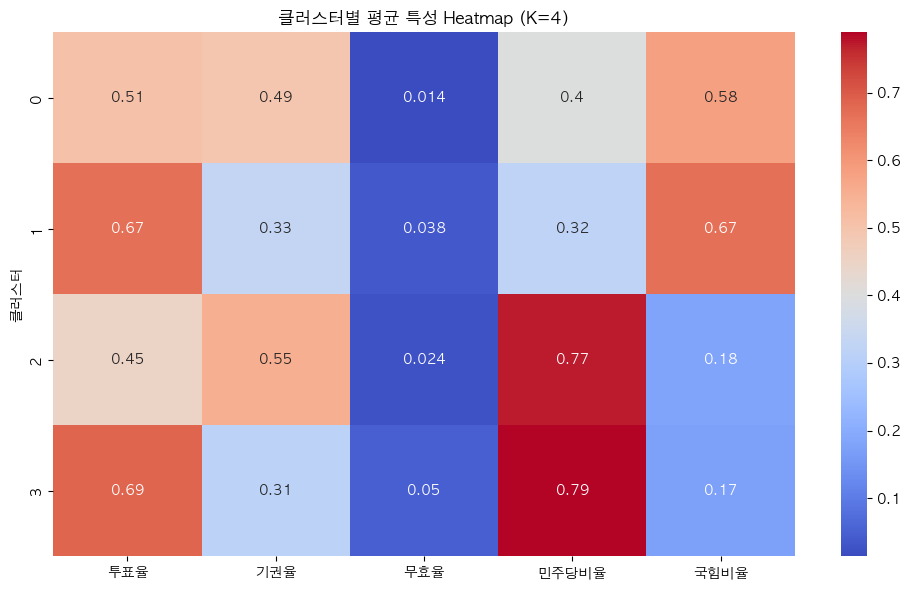

In [36]:
# 정규화 및 KMeans 클러스터링 (K=5)
features = ['투표율', '기권율', '무효율', '민주당비율', '국힘비율']
X_scaled = MinMaxScaler().fit_transform(cluster_data[features])
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_data['클러스터'] = kmeans.fit_predict(X_scaled)

# 5. 클러스터별 평균값 집계 및 히트맵 출력
cluster_means_7 = cluster_data.groupby('클러스터')[features].mean().round(3)

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means_7, annot=True, cmap='coolwarm')
plt.title("클러스터별 평균 특성 Heatmap (K=4)")
plt.tight_layout()
plt.show()


#### 클러스터별 시나리오 요약 

|클러스터|주요 특성 요약|시나리오|
|---|---|---|
|0|국힘↑, 민주당↓, 평균적 참여|국힘 강세, 평균적 지역|
|1|국힘↑, 민주당↓, 투표율↑|국힘 압도, 적극적 참여|
|2|민주당↑, 국힘↓, 투표율↓|민주당 강세, 무관심 지역|
|3|민주당↑, 국힘↓, 투표율↑|민주당 압도, 적극적 참여|


1. 클러스터 0  
→ 평균적인 투표율과 기권율을 보이며, 국힘(국민의힘) 지지율이 민주당보다 높음.  
→ 국힘 강세, 평균적 참여 지역 경쟁은 있으나 국힘이 우세한 지역군.  
2. 클러스터 1  
→ 투표율이 높고, 기권율이 낮음. 국힘 지지율이 매우 높고, 민주당은 낮음.  
→ 국힘 압도적 강세, 적극적 참여 지역 정치적 관심이 높고, 국힘 쏠림이 뚜렷한 지역군.  
3. 클러스터 2  
→ 투표율이 낮고, 기권율이 높음. 민주당 지지율이 매우 높고, 국힘은 매우 낮음.  
→ 민주당 강세, 무관심(기권↑) 지역 정치적 무관심 속에서 민주당 지지층이 결집된 지역군.  
3. 클러스터 3  
→ 투표율이 매우 높고, 기권율이 매우 낮음. 민주당 지지율이 압도적으로 높음, 국힘은 매우 낮음.  
→ 민주당 압도적 강세, 적극적 참여 지역 정치적 관심이 매우 높고, 민주당 쏠림이 뚜렷한 지역군.  

### 2. 회귀분석


In [39]:
print(cluster_data.head(10))

# 회귀분석 
X = cluster_data[['투표율']]
y = cluster_data['민주당비율']

model = LinearRegression().fit(X, y)
print("회귀계수:", model.coef_)
print("절편:", model.intercept_)
print("설명력(R²):", model.score(X, y))

    선거구명  구시군명 읍면동명   구분      선거인수       투표수  후보자별 득표수  Unnamed: 7 Unnamed: 8  \
0  서울특별시   종로구   합계  NaN  129816.0   70657.0   28327.0     40145.0      1,151   
1  서울특별시    중구   합계  NaN  112039.0   60323.0   23811.0     34866.0        696   
2  서울특별시   용산구   합계  NaN  199061.0  104787.0   34614.0     67579.0      1,354   
3  서울특별시   성동구   합계  NaN  251990.0  139761.0   51996.0     84320.0      1,510   
4  서울특별시   광진구   합계  NaN  305462.0  157005.0   62217.0     90734.0      1,845   
5  서울특별시  동대문구   합계  NaN  302024.0  156964.0   63157.0     89470.0      2,011   
6  서울특별시   중랑구   합계  NaN  348762.0  177701.0   76660.0     96447.0      1,870   
7  서울특별시   성북구   합계  NaN  379123.0  202235.0   85825.0    110962.0      2,698   
8  서울특별시   강북구   합계  NaN  268130.0  133390.0   58962.0     70747.0      1,515   
9  서울특별시   도봉구   합계  NaN  280913.0  148579.0   61946.0     83072.0      1,457   

  Unnamed: 9  ... Unnamed: 11         계   무효투표수       기권수       투표율       기권율  \
0        226  ...          

### 3. 정당별 득표율 (민주당승률)
- 엑셀안 지도좌표를 그려 위치 표기 
- 정당별 승률계산하여 온도값 표기 

In [54]:
BORDER_LINES = [
    [(5, 1), (5,2), (7,2), (7,3), (11,3), (11,0)], # 인천
    [(5,4), (5,5), (2,5), (2,7), (4,7), (4,9), (7,9),(7,7), (9,7), (9,5), (10,5), (10,4), (5,4)], # 서울
    [(1,7), (1,8), (3,8), (3,10), (10,10), (10,7),(12,7), (12,6), (11,6), (11,5), (12, 5), (12,4),(11,4), (11,3)], # 경기도
    [(8,10), (8,11), (6,11), (6,12)], # 강원도
    [(12,5), (13,5), (13,4), (14,4), (14,5), (15,5), (15,4), (16,4), (16,2)], # 충청북도
    [(16,4), (17,4), (17,5), (16,5), (16,6), (19,6), (19,5), (20,5), (20,4), (21,4), (21,3), (19,3), (19,1)], # 전라북도
    [(13,5), (13,6), (16,6)], # 대전시
    [(13,5), (14,5)], #세종시
    [(21,2), (21,3), (22,3), (22,4), (24,4), (24,2), (21,2)], #광주
    [(20,5), (21,5), (21,6), (23,6)], #전라남도
    [(10,8), (12,8), (12,9), (14,9), (14,8), (16,8), (16,6)], #충청북도
    [(14,9), (14,11), (14,12), (13,12), (13,13)], #경상북도
    [(15,8), (17,8), (17,10), (16,10), (16,11), (14,11)], #대구
    [(17,9), (18,9), (18,8), (19,8), (19,9), (20,9), (20,10), (21,10)], #부산
    [(16,11), (16,13)], #울산
    [(27,5), (27,6), (25,6)] #경상남도
]

def drawKorea(targetData, blockedMap, cmapname):
    gamma = 0.75
    whitelabelmin = 20.
    datalabel = targetData
    tmp_max = max([ np.abs(min(blockedMap[targetData])), 
                    np.abs(max(blockedMap[targetData]))])
    vmin, vmax = -tmp_max, tmp_max

    print(vmin, vmax)

    mapdata = blockedMap.pivot_table(index='y', columns='x', values=targetData)
    masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)
    
    plt.figure(figsize=(9, 11))
    plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=cmapname, 
               edgecolor='#aaaaaa', linewidth=0.5)

    # 지역 이름 표시
    for idx, row in blockedMap.iterrows():
        # 광역시는 구 이름이 겹치는 경우가 많아서 시단위 이름도 같이 표시한다. 
        #(중구, 서구)
        if len(row['ID'].split())==2:
            dispname = '{}\n{}'.format(row['ID'].split()[0], row['ID'].split()[1])
        elif row['ID'][:2]=='고성':
            dispname = '고성'
        else:
            dispname = row['ID']

        # 서대문구, 서귀포시 같이 이름이 3자 이상인 경우에 작은 글자로 표시한다.
        if len(dispname.splitlines()[-1]) >= 3:
            fontsize, linespacing = 10.0, 1.1
        else:
            fontsize, linespacing = 11, 1.

        annocolor = 'white' if np.abs(row[targetData]) > whitelabelmin else 'black'
        plt.annotate(dispname, (row['x']+0.5, row['y']+0.5), weight='bold',
                     fontsize=fontsize, ha='center', va='center', color=annocolor,
                     linespacing=linespacing)

    # 시도 경계 그린다.
    for path in BORDER_LINES:
        ys, xs = zip(*path)
        plt.plot(xs, ys, c='black', lw=2)

    plt.gca().invert_yaxis()

    plt.axis('off')

    cb = plt.colorbar(shrink=.1, aspect=10)
    cb.set_label(datalabel)

    plt.tight_layout()
    plt.show()

-0.7596474595315847 0.7596474595315847


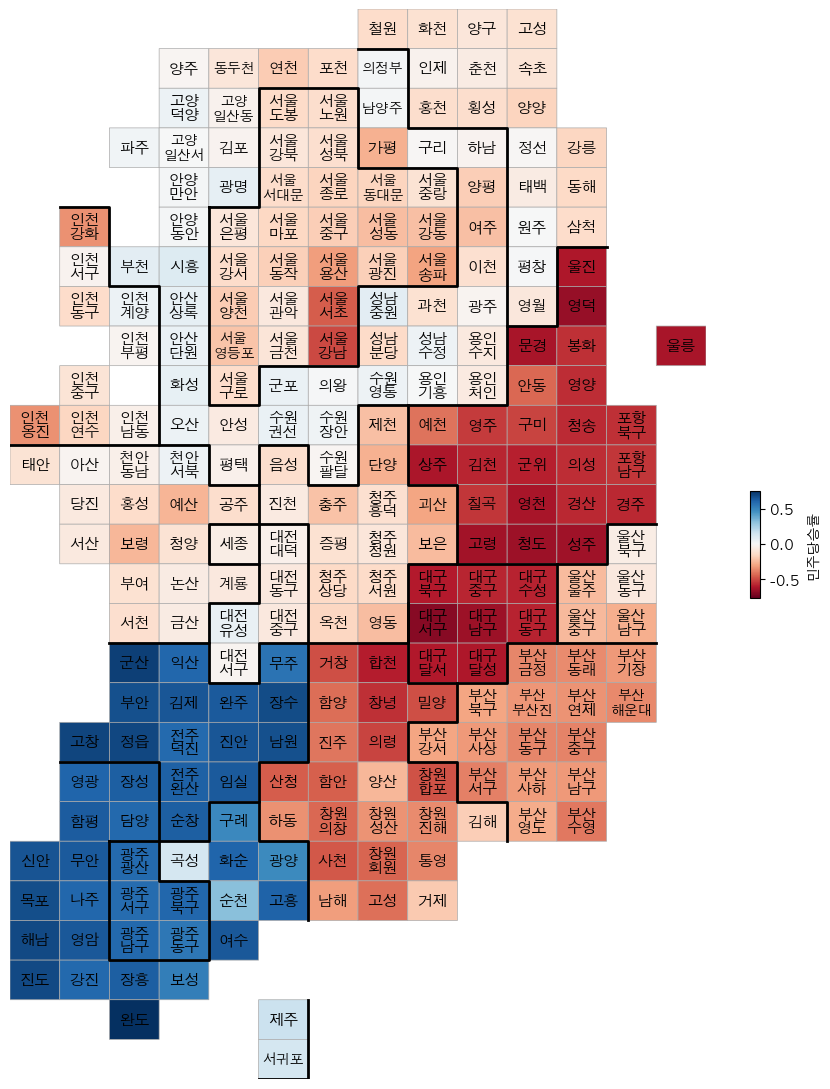

In [ ]:
sido_name = cluster_data['선거구명']
sido_name = [name[:2] if name[:2] in ['서울', '부산', '대구', '광주', '인천', '대전', '울산']
                          else '' for name in sido_name]

def cut_char_sigu(name):
    return name if len(name) == 2 else name[:-1]

sigun_name = [''] * len(cluster_data)

for n in cluster_data.index:
    each = cluster_data['구시군명'][n]
    if each[:2] in ['수원', '성남', '안양', '안산', '고양', 
                    '용인', '청주', '천안', '전주', '포항', '창원']:
        sigun_name[n] = re.split('시', each)[0] + ' ' + \
                         cut_char_sigu(re.split('시', each)[1])
    else:
        sigun_name[n] = cut_char_sigu(each)

ID_candi = [sido_name[n] + ' ' + sigun_name[n] for n in range(0, len(sigun_name))]
ID_candi = [name[1:] if name[0] == ' ' else name for name in ID_candi]
ID_candi = [name[:2] if name[:2] == '세종' else name for name in ID_candi]

cluster_data['ID'] = ID_candi

## 엑셀에 보유줄 위치 좌표를 표기 하고 x,y 표기 
draw_korea_raw = pd.read_excel("draw_korea.xlsx")
draw_korea_raw_stacked = pd.DataFrame(draw_korea_raw.stack())
draw_korea_raw_stacked.reset_index(inplace = True)
draw_korea_raw_stacked.rename(columns = {'level_0':'y', 'level_1':'x', 0:'ID'},
                              inplace = True)
draw_korea = draw_korea_raw_stacked.copy()

# 중복된 지명의 경우 나누고 부천의 경우 3개로 나눠야 하지만 데이터 부족으로 한개만 표기 
cluster_data[cluster_data['ID'] == '고성']
cluster_data.loc[125, 'ID'] = '고성(강원)'
cluster_data.loc[233, 'ID'] = '고성(경남)'
cluster_data.loc[228, 'ID'] = '창원 합포'
cluster_data.loc[229, 'ID'] = '창원 회원'

set(draw_korea['ID'].unique()) - set(cluster_data['ID'].unique())
set(cluster_data['ID'].unique()) - set(draw_korea['ID'].unique())
final_elect_data = pd.merge(cluster_data, draw_korea, how = 'left', on = ['ID'] )
# 민주당 비율 - 국힘비율
final_elect_data['민주당승률'] = final_elect_data['민주당비율'] - final_elect_data['국힘비율']
# 국힘비율 - 민주당 비율 
final_elect_data['국힘승률'] = final_elect_data['국힘비율'] - final_elect_data['민주당비율']

drawKorea('민주당승률', final_elect_data, 'RdBu')